In [55]:
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import umap
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from IPython.display import display
from ipyfilechooser import FileChooser
%matplotlib widget
from scipy.stats import zscore
from sklearn.datasets import make_swiss_roll
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import Isomap
import networkx as nx
from scipy.stats import entropy
import warnings
import pickle
import matplotlib.cm as cm
import ast
from pathlib import Path

from scipy.spatial.distance import pdist, squareform
from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp
import diptest
import random
from collections import Counter, defaultdict

from mpl_toolkits.axes_grid1 import make_axes_locatable
warnings.filterwarnings("ignore")

In [2]:
try: # tries to retrieve dpath either from a previous run or from a previous notebook
    %store -r dpath
except:
    print("the path was not defined in store")
    #dpath = "/Users/mb/Documents/Syntuitio/AudreyHay/PlanB/ExampleRedLines/2022_08_06/13_30_01/My_V4_Miniscope/"
    dpath = "//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/"

fc1 = FileChooser(dpath,select_default=True, show_only_dirs = True, title = "<b>Folder with videos</b>")
display(fc1)

# Sample callback function
def update_my_folder(chooser):
    global dpath
    dpath = chooser.selected
    %store dpath
    return 

# Register callback function
fc1.register_callback(update_my_folder)

FileChooser(path='\\10.69.168.1\crnldata\waking\audrey_hay\L1imaging\Analysed2025_AB\_baseline_analysis\VigSt_…

In [58]:
try :
    combined_df = pd.read_excel(f'{dpath}/VigStates_Global.pkl', index_col=0)
except:
    with open(f'{dpath}/VigStates_Global.pkl', 'rb') as pickle_file:
        combined_df = pickle.load(pickle_file)
        
desired_order = ['AW','QW', 'NREM', 'IS', 'REM', 'undefined']   
NrSubtype='L1NDNF_mice' #['L1NDNF_mice','L2_3_mice']

In [ ]:
combined_df['Unique_Unit'] = combined_df['Unique_Unit'].astype(int).astype(str)
combined_df['UnitNumber'] = combined_df['UnitNumber'].astype(str)
combined_df['UnitValue'] = combined_df['UnitValue'].astype(str)
combined_df['Unit_ID'] = combined_df['Mice'] + combined_df['Unique_Unit']
combined_df['Substate_ID'] = combined_df['Mice'] + combined_df['Session'] + combined_df['Substate'] + combined_df['SubstateNumber'].astype(str)
combined_df['Session_ID'] = combined_df['Session_Date'] + '_' + combined_df['Session_Time'].astype(str)
combined_df['NormalizedAUC_calcium'] = combined_df['AUC_calcium'] / combined_df['DurationSubstate']

combined_df_Drug=combined_df.copy()
combined_df_Drug = combined_df_Drug[combined_df_Drug['Drug'] == 'baseline']
combined_df_Drug = combined_df_Drug[combined_df_Drug['NeuronType'] == NrSubtype]

DataType='NormalizedAUC_calcium' # NormalizedAUC_calcium, SpikeActivityHz , DeconvSpikeMeanActivity, CalciumActivity

data_origin = combined_df_Drug.pivot_table(index='Unit_ID', columns='Substate', values=DataType, aggfunc='mean')   
try : data_origin = data_origin[desired_order]
except: pass

In [69]:
try: del data_origin['undefined']
except : pass
del data_origin['IS']
data_origin=data_origin.dropna(axis=0)
vigst_nb=np.shape(data_origin)[1]
print(np.shape(data_origin))
data=data_origin.div(data_origin.sum(axis=1), axis=0)

(108, 4)


### HDBSCAN Clustering

In [80]:
n_neighbors= 90 #8
min_dist=.9 #.9

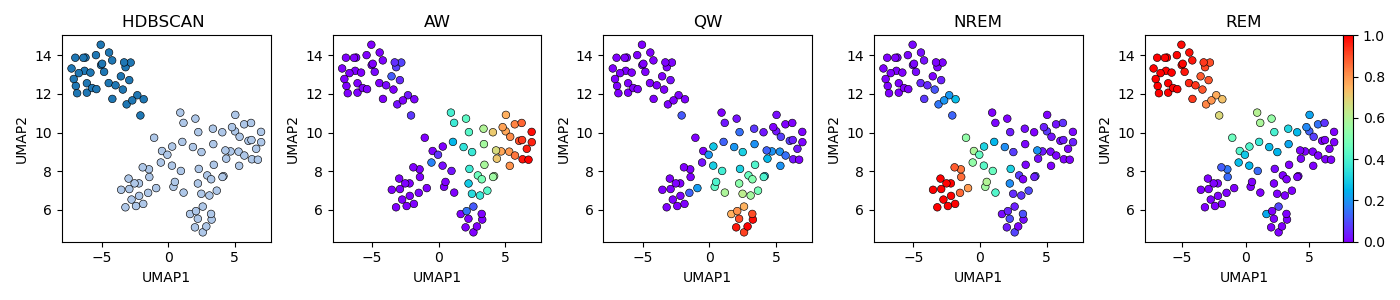

Entropy of distribution: 4.63 (higher = more uniform)
Avg. local distance ratio (max/min): 24.91 (closer to 1 = more Euclidean-like)
Connected Components in k-NN graph: 1 (should be 1 for full connectivity)


In [81]:
# Perform UMAP
umap_model = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2, random_state=None) 
#n_neighbors=15: range 2 to 100. Controls the balance between local and global structure 
#n_components=2 : range 2 to 100.Reduces the data to 2D for visualization 
#min_dist=0.1: Controls the spread of points. Smaller values emphasize local structure
X_umap = umap_model.fit_transform(data)

hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=1, prediction_data=True).fit(X_umap)
embedding_df = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])
labels = hdbscan_model.fit_predict(X_umap)
embedding_df['Cluster'] = labels

# Plotting the results

cmap = sns.diverging_palette(10, 133, as_cmap=True)
plt.close()
plt.figure(figsize=(14, 3))

# Plot Results
plt.subplot(1,5,1)
sns.scatterplot(x='UMAP1', y='UMAP2', hue='Cluster', palette='tab20', data=embedding_df, s=30, edgecolor='k', legend=False)
plt.title('HDBSCAN ')

plt.subplot(1,5,2)
sns.scatterplot(x='UMAP1', y='UMAP2', data=embedding_df, s=30, edgecolor='k', hue=data['AW'].values, palette='rainbow', legend=False)
plt.title('AW')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

plt.subplot(1,5,3)
sns.scatterplot(x='UMAP1', y='UMAP2', data=embedding_df, s=30, edgecolor='k', hue=data['QW'].values, palette='rainbow', legend=False)
plt.title('QW')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

plt.subplot(1,5,4)
sns.scatterplot(x='UMAP1', y='UMAP2', data=embedding_df, s=30, edgecolor='k', hue=data['NREM'].values, palette='rainbow', legend=False)
plt.title('NREM')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

plt.subplot(1,5,5)
ax=sns.scatterplot(x='UMAP1', y='UMAP2', data=embedding_df, s=30, edgecolor='k', hue=data['REM'].values, palette='rainbow', legend=False)
plt.title('REM')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0)
plt.colorbar(plt.cm.ScalarMappable(cmap='rainbow'), cax=cax)
plt.tight_layout()

plt.show()


#X, color = make_swiss_roll(n_samples=2000, noise=0.1) ## Generate synthetic manifold data (Swiss Roll)
X = X_umap

# ---- Assumption 1: Uniform distribution (check density variation) ----
def check_uniformity(X, n_bins=30):
    hist, _ = np.histogramdd(X, bins=n_bins)
    hist = hist.flatten()
    hist = hist[hist > 0]
    hist = hist / np.sum(hist)
    ent = entropy(hist)
    print(f"Entropy of distribution: {ent:.2f} (higher = more uniform)")
    
check_uniformity(X)

# ---- Assumption 2: Locally Euclidean (constant metric) ----
def check_local_metric(X, n_neighbors=n_neighbors):
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(X)
    distances, indices = nbrs.kneighbors(X)

    # Compute ratio of distances between nearest neighbor and farthest neighbor in local patch
    ratios = distances[:, -1] / (distances[:, 1] + 1e-10)
    print(f"Avg. local distance ratio (max/min): {np.mean(ratios):.2f} (closer to 1 = more Euclidean-like)")
    
check_local_metric(X)

# ---- Assumption 3: Locally connected ----
def check_local_connectivity(X, n_neighbors=n_neighbors):
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(X)
    graph = nbrs.kneighbors_graph(X).tocoo()
    
    G = nx.Graph()
    for i, j in zip(graph.row, graph.col):
        G.add_edge(i, j)
    
    n_components = nx.number_connected_components(G)
    print(f"Connected Components in k-NN graph: {n_components} (should be 1 for full connectivity)")

check_local_connectivity(X)

### Mouse repartition in cluster

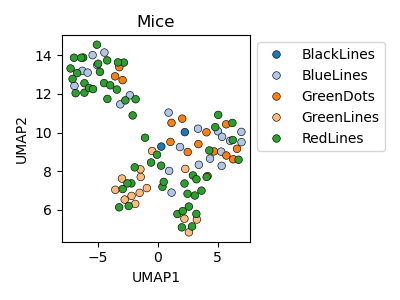

In [82]:
plt.close()
plt.figure(figsize=(4, 3))
sns.scatterplot(x='UMAP1', y='UMAP2', data=embedding_df, s=30, edgecolor='k', hue=data.index.str.replace(r'\d+', '', regex=True).values, palette='tab20', legend=True)
plt.title('Mice')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

Evaluate clustering

In [47]:
if len(set(labels)) > 1 and -1 not in set(labels):
    score = silhouette_score(embedding, labels)
    print(f"Silhouette Score: {score:.2f}.  Notes: 1 → Well-clustered. 0 → Overlapping clusters. -1 → Misclassified samples.")
else:
    print("Silhouette Score cannot be calculated. Check for multiple clusters.")
    

if len(set(labels)) > 1 and -1 not in set(labels):
    db_score = davies_bouldin_score(embedding, labels)
    print(f"Davies-Bouldin Index: {db_score:.2f}.   Notes: Lower values indicate better clustering.")
else:
    print("Davies-Bouldin Index cannot be calculated. Check for multiple clusters.")


if len(set(labels)) > 1 and -1 not in set(labels):
    ch_score = calinski_harabasz_score(embedding, labels)
    print(f"Calinski-Harabasz Index: {ch_score:.2f}.    Notes: Higher values indicate better clustering.")
else:
    print("Calinski-Harabasz Index cannot be calculated. Check for multiple clusters.")

NameError: name 'embedding' is not defined

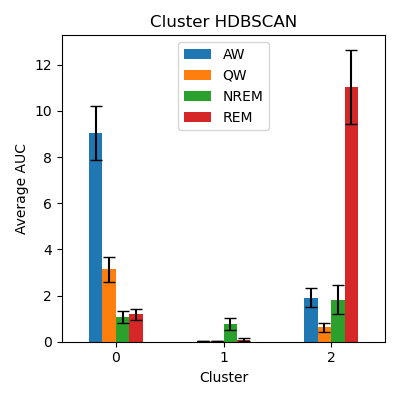

ClusterHDBSCAN
0     99
1     22
2    107
dtype: int64


In [49]:
data_origin['ClusterHDBSCAN'] = labels
grouped = data_origin.groupby('ClusterHDBSCAN')
means = grouped[data_origin.columns[:vigst_nb]].mean()
sems = grouped[data_origin.columns[:vigst_nb]].sem()

# Plot
ax = means.plot(kind='bar', yerr=sems, capsize=4, figsize=(4, 4))
plt.title('Cluster HDBSCAN')
plt.ylabel('Average AUC')
plt.xlabel('Cluster')
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout()
plt.show()
print(grouped.size())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


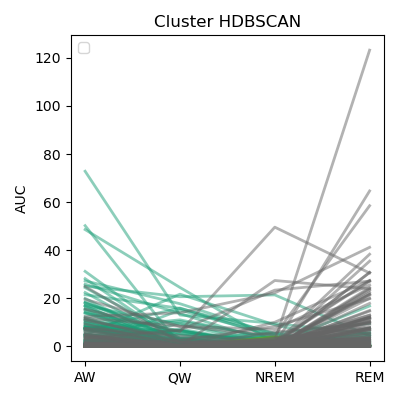

ClusterHDBSCAN
0     99
1     22
2    107
dtype: int64


In [50]:
plt.figure(figsize=(4, 4))

# Generate a color for each group
groups = list(grouped.groups.keys())
colors = cm.get_cmap('Dark2', len(groups))

# Loop through each group
for idx, (name, group) in enumerate(grouped):
    color = colors(idx)  # assign a color based on group index
    for i in range(len(group)):
        plt.plot(group.columns[:-1], group.iloc[i][:-1], color=color, alpha=0.5, linewidth=2)

plt.title('Cluster HDBSCAN')
plt.ylabel('AUC')
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout()
plt.show()

print(grouped.size())

Save clusters

In [51]:
merged = pd.merge(combined_df, data_origin['ClusterHDBSCAN'], on='Unit_ID', how='outer') 
filenameOutAUC = f'{dpath}/VigStates_Global_cluster.xlsx'
merged.to_excel(filenameOutAUC)

filenameOut = f'{dpath}/VigStates_Global_cluster.pkl'
with open(filenameOut, 'wb') as pickle_file:
    pickle.dump(merged, pickle_file)

### Per sessions

In [52]:
grouped=combined_df_Drug.groupby(['Unit_ID', 'Session_ID', 'Substate'])['NormalizedAUC_calcium'].mean()
grouped = grouped.reset_index()
grouped2=grouped.pivot_table(index=[grouped['Unit_ID'], grouped['Session_ID']], columns='Substate', values='NormalizedAUC_calcium')
try : grouped2 = grouped2[desired_order]
except: pass
del grouped2['IS']
del grouped2['undefined']

d=[]
test=pd.DataFrame(d, columns=['Cluster_sessID'])

for i in np.arange(len(grouped2)):
    new_point=np.array(grouped2.iloc[i])
    if not sum(np.isnan(new_point)): 
        new_point_umap = umap_model.transform(new_point.reshape(1, -1))
        new_label, new_prob = hdbscan.approximate_predict(hdbscan_model, new_point_umap)
        test.loc[i,'Cluster_sessID']=new_label[0].astype(str)
    else:
        test.loc[i,'Cluster_sessID']=None
grouped2['Cluster_sessID'] = test['Cluster_sessID'].values

grouped3 = grouped2.reset_index()
grouped3 = grouped3.drop(columns=['AW', 'QW', 'NREM', 'REM'])
grouped3 = grouped3.dropna(subset=['Cluster_sessID'])
grouped3 = grouped3[grouped3['Unit_ID'].duplicated(keep=False)] #remove units that only appears in one sessionID


# ⏱ Convert to datetime
grouped3['Session_ID'] = pd.to_datetime(grouped3['Session_ID'], format='%Y-%m-%d_%H-%M-%S')
df_sorted = grouped3.sort_values(['Unit_ID', 'Session_ID'])
grouped = df_sorted.groupby('Unit_ID')

# Build summary DataFrame
summary_df = grouped.agg(
    first_date=('Session_ID', 'first'),
    last_date=('Session_ID', 'last'),
    first_Cluster_sessID=('Cluster_sessID', 'first'),
    last_Cluster_sessID=('Cluster_sessID', 'last')
)

# Calculate number of days between first and last
summary_df['days_between'] = (
    summary_df['last_date'].dt.floor('D') - summary_df['first_date'].dt.floor('D')
).dt.days

# Reorder and rename
summary_df = summary_df.reset_index()[['Unit_ID', 'days_between', 'first_Cluster_sessID', 'last_Cluster_sessID']]
summary_df.columns = ['Unit_ID', 'days_between', 'first', 'last']

# Remove if on the same day?
summary_df=summary_df[summary_df['days_between']>=0]

print(np.round(np.mean(summary_df['days_between']),1), '+/-', np.round(np.std(summary_df['days_between']) / np.sqrt(len(summary_df['days_between'])), 1) , 'days on average between the first and last session')

print('n = ', len(summary_df))

9.9 +/- 3.2 days on average between the first and last session
n =  35


In [53]:
import plotly.graph_objects as go

labels = ["Cluster0", "Cluster1", "Cluster2", "Cluster0", "Cluster1", "Cluster2"]

a=len(summary_df[(summary_df['first'] == '0') & (summary_df['last'] == '0')].index.tolist())
b=len(summary_df[(summary_df['first'] == '0') & (summary_df['last'] == '1')].index.tolist())
c=len(summary_df[(summary_df['first'] == '0') & (summary_df['last'] == '2')].index.tolist())
d=len(summary_df[(summary_df['first'] == '1') & (summary_df['last'] == '0')].index.tolist())
e=len(summary_df[(summary_df['first'] == '1') & (summary_df['last'] == '1')].index.tolist())
f=len(summary_df[(summary_df['first'] == '1') & (summary_df['last'] == '2')].index.tolist())
g=len(summary_df[(summary_df['first'] == '2') & (summary_df['last'] == '0')].index.tolist())
h=len(summary_df[(summary_df['first'] == '2') & (summary_df['last'] == '1')].index.tolist())
i=len(summary_df[(summary_df['first'] == '2') & (summary_df['last'] == '2')].index.tolist())

# Indexes in the labels list
source = [0, 0, 0, 1, 1, 1, 2, 2, 2]
target = [3, 4, 5, 3, 4, 5, 3, 4, 5]
value  = [a, b, c, d, e, f, g, h, i]

fig = go.Figure(data=[go.Sankey(
    node=dict(label=labels),
    link=dict(source=source, target=target, value=value)
)])

fig.update_layout(
    font_size=12,
    width=300,  # Width of the figure
    height=400  # Height of the figure
)


fig.show()
plt.tight_layout()


print(np.round((a+e+i)/35*100), 'percent of cells in the same cluster')

69.0 percent of cells in the same cluster


Plot a new point on the umap & get its cluster

In [16]:
new_point=np.array([0, .25, .25, .5])

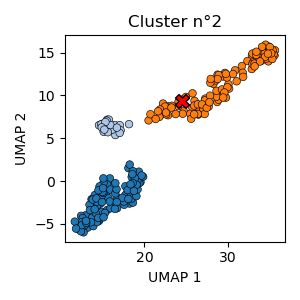

In [17]:
new_point_umap = umap_model.transform(new_point.reshape(1, -1))
new_label, new_prob = hdbscan.approximate_predict(hdbscan_model, new_point_umap)

# 6. Plot
plt.figure(figsize=(3, 3))

# Plot existing clustered points
sns.scatterplot(x='UMAP1', y='UMAP2', hue='Cluster', palette='tab20', data=embedding_df, s=30, edgecolor='k', legend=False)

# Plot the new point
plt.scatter(new_point_umap[:, 0], new_point_umap[:, 1], c='red', s=100, marker='X', edgecolor='k')
plt.title(f'Cluster n°{new_label[0]}')
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.tight_layout()
plt.show()

### Neuron distances relative to cluster ID

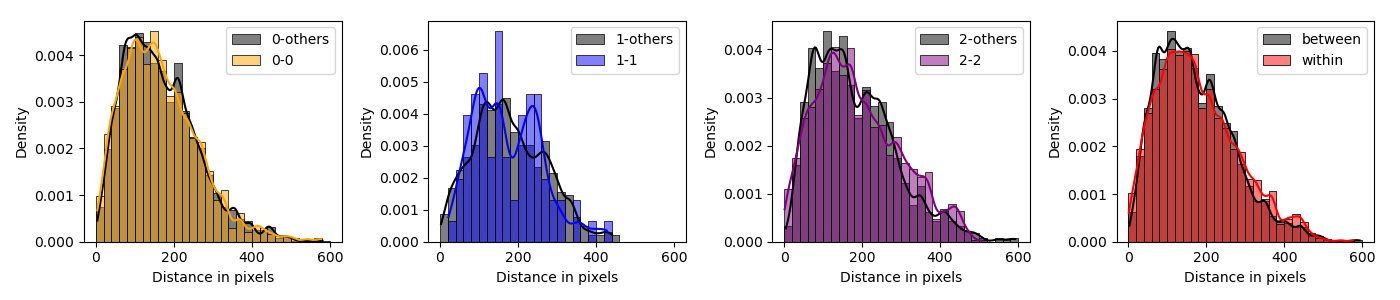

C0 = K-S Test: p = 0.86
C1 = K-S Test: p = 0.77
C2 = K-S Test: p = 0.01
All = K-S Test: p = 0.02


In [54]:
df_cluster = pd.read_excel(f'{Path(dpath)}/VigStates_Global_cluster.xlsx', index_col=0)
df_cluster = df_cluster[df_cluster['NeuronType'] == 'L1NDNF_mice']
df_cluster_c = df_cluster.drop_duplicates(subset='Unit_ID', keep='first')
df_cluster_c = df_cluster_c.dropna(subset=['ClusterHDBSCAN'])

def extract_xy(coord_str):
    val = ast.literal_eval(coord_str)
    # Handle nested list: [[x], [y]]
    if isinstance(val[0], list):
        x, y = val[0][0], val[1][0]
    else:
        x, y = val[0], val[1]
    return pd.Series([x, y])

df_cluster_c[['x', 'y']] = df_cluster_c['UnitLocation'].apply(extract_xy)

within_dists_all = []
within_dists_c0 = []
within_dists_c1 = []
within_dists_c2 = []
between_dists_all = []
between_dists_c0 = []
between_dists_c1 = []
between_dists_c2 = []

for indiv_id, group in df_cluster_c.groupby('Mice'):
    coords = group[['x', 'y']].values
    labels = group['ClusterHDBSCAN'].values
    dist_matrix = squareform(pdist(coords))    
    for i in range(len(group)):
        for j in range(i + 1, len(group)):
            d = dist_matrix[i, j]
            if labels[i] == labels[j]:
                within_dists_all.append(d)
                if labels[i] == 0:
                    within_dists_c0.append(d)
                elif labels[i] == 1:
                    within_dists_c1.append(d)
                elif labels[i] == 2:
                    within_dists_c2.append(d)
            else:
                between_dists_all.append(d)
                if labels[i] == 0:
                    between_dists_c0.append(d)
                elif labels[i] == 1:
                    between_dists_c1.append(d)
                elif labels[i] == 2:
                    between_dists_c2.append(d)

# --- Plot distributions ---
fig, axes = plt.subplots(1, 4, figsize=(14, 3))

plt.subplot(1,4,1)
sns.histplot(between_dists_c0, bins=30, binrange=(0, 600),color='black', label='0-others', kde=True, stat="density", alpha=0.5, kde_kws={'bw_adjust': 0.5})
sns.histplot(within_dists_c0, bins=30, binrange=(0, 600),color='orange', label='0-0', kde=True, stat="density", kde_kws={'bw_adjust': 0.5})
plt.legend()
plt.xlabel("Distance in pixels")
plt.ylabel("Density")

plt.subplot(1,4,2)
sns.histplot(between_dists_c1, bins=30,binrange=(0, 600), color='black', label='1-others', kde=True, stat="density", alpha=0.5, kde_kws={'bw_adjust': 0.5})
sns.histplot(within_dists_c1, bins=30, binrange=(0, 600),color='blue', label='1-1', kde=True, stat="density", alpha=0.5, kde_kws={'bw_adjust': 0.5})
plt.legend()
plt.xlabel("Distance in pixels")
plt.ylabel("Density")

plt.subplot(1,4,3)
sns.histplot(between_dists_c2, bins=30, binrange=(0, 600),color='black', label='2-others', kde=True, stat="density", alpha=0.5, kde_kws={'bw_adjust': 0.5})
sns.histplot(within_dists_c2, bins=30, binrange=(0, 600), color='purple', label='2-2', kde=True, stat="density", alpha=0.5, kde_kws={'bw_adjust': 0.5})
plt.legend()
plt.xlabel("Distance in pixels")
plt.ylabel("Density")
plt.tight_layout()


plt.subplot(1,4,4)
sns.histplot(between_dists_all, bins=30, binrange=(0, 600),color='black', label='between', kde=True, stat="density", alpha=0.5, kde_kws={'bw_adjust': 0.5})
sns.histplot(within_dists_all, bins=30, binrange=(0, 600),color='red', label='within', kde=True, stat="density", kde_kws={'bw_adjust': 0.5})
plt.legend()
plt.xlabel("Distance in pixels")
plt.ylabel("Density")

plt.show()


stat, p =ks_2samp(within_dists_c0, between_dists_c0)
print(f"C0 = K-S Test: p = {p:.2f}")
stat, p =ks_2samp(within_dists_c1, between_dists_c1)
print(f"C1 = K-S Test: p = {p:.2f}")
stat, p =ks_2samp(within_dists_c2, between_dists_c2)
print(f"C2 = K-S Test: p = {p:.2f}")
stat, p =ks_2samp(within_dists_all, between_dists_all)
print(f"All = K-S Test: p = {p:.2f}")

#dip, pval = diptest.diptest(np.array(within_dists_c1))
#print(f"C1 = Bimodal distribution Test: p = {pval:.2f}")